# Experiment some machine learning models

In [5]:
# import necessary packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import datetime
import mlflow
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, RocCurveDisplay, roc_auc_score

from sklearn.base import BaseEstimator, TransformerMixin

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [6]:
# read train set as a pandas dataframe
full_set = pd.read_csv('../data/dataset.csv')
train_set = pd.read_csv('../data/train_set.csv')
test_set = pd.read_csv('../data/test_set.csv')

In [7]:
# select only the features that we are going to use
X = train_set.drop(['fraude'], axis=1)
y = train_set['fraude']

# Preprocessing

In [8]:
class CountryMapper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        def map_countries(country):
            if country == 'BR':
                return 'BR'
            elif country == 'AR':
                return 'AR'
            elif country == 'UY':
                return 'UY'
            elif country == 'US':
                return 'US'
            else:
                return 'outros'
        
        X['pais'] = X['pais'].apply(map_countries)
        return X
    
    def get_feature_names_out(self, X):
        return ['pais']

In [9]:
qualitative_feat = ['score_1', 'entrega_doc_1']
entrega_doc_2_feat = ['entrega_doc_2']
entrega_doc_3_feat = ['entrega_doc_3']
pais_feat = ['pais']

# quantitative_continue_feat = [
#     'score_2', 'score_3', 'score_4', 'score_5', 'score_6', 'score_7', 'score_9', 'score_10', 'valor_compra']

quantitative_continue_feat = [
    'score_4', 'score_9', 'score_10', 'valor_compra']

qualitative_preproc = make_pipeline(
        SimpleImputer(strategy='most_frequent'))

entrega_doc_2_preproc = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='null'),
        OneHotEncoder(drop='first'))

entrega_doc_3_preproc = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(drop='if_binary'))

pais_preproc = make_pipeline(
        CountryMapper(),
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder(drop='first'))

quantitative_continue_preproc = make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler())

# apply the respective transformations with columntransformer method
preprocessor = ColumnTransformer([
    ('entrega_doc_1_feat', qualitative_preproc, qualitative_feat),
    ('entrega_doc_2_feat', entrega_doc_2_preproc, entrega_doc_2_feat),
    ('entrega_doc_3_feat', entrega_doc_3_preproc, entrega_doc_3_feat),
    ('pais_feat', pais_preproc, pais_feat),
    ('quantitative_continue_feat', quantitative_continue_preproc, quantitative_continue_feat)],
    remainder='drop')

processed_features = qualitative_feat + entrega_doc_2_feat + entrega_doc_3_feat + pais_feat + quantitative_continue_feat

# Baseline and business return of the last model

In [10]:
def map_score(score_fraude, threshold):
    if score_fraude >= threshold:
        return 1
    else:
        return 0

# list to store the metrics
thresholds = []
train_balanced_accuracies = []
test_balanced_accuracies = []
revenue = []
loss = []
profit = []

# create a copy
business_return = test_set.copy()

# calculate the predictions for different thresholds
for threshold in range(101):
    business_return[f'y_pred_last_model_{threshold}'] = business_return['score_fraude_modelo'].apply(lambda x: map_score(x, threshold))

    # calculate the accuracies
    test_balanced_accuracy = balanced_accuracy_score(business_return['fraude'], business_return[f'y_pred_last_model_{threshold}'])

    # calculate the revenue
    revenues = business_return.loc[(test_set['fraude'] == 0) &
                                   (business_return[f'y_pred_last_model_{threshold}'] == 0)]
    total_revenue = np.sum(revenues['valor_compra'].values)
    total_revenue = total_revenue * 0.1

    # calculate the fraud losses
    losses = business_return.loc[(business_return['fraude'] == 1) &
                                 (business_return[f'y_pred_last_model_{threshold}'] == 0)]
    total_losses = np.sum(losses['valor_compra'].values)

    # calculate the profit
    total_profit = total_revenue - total_losses

    # put the values in lists
    thresholds.append(threshold)
    test_balanced_accuracies.append(test_balanced_accuracy)
    revenue.append(total_revenue)
    loss.append(total_losses)
    profit.append(total_profit)

# Criar o DataFrame com as métricas
metrics_df = pd.DataFrame({
    'Threshold': thresholds,
    'Test_Balanced_Accuracy': test_balanced_accuracies,
    'Revenue': revenue,
    'Fraud_losses': loss,
    'Profit': profit
})

In [11]:
metrics_df

,Threshold,Test_Balanced_Accuracy,Revenue,Fraud_losses,Profit
0,0,0.500000,0.000,0.00,0.000
1,1,0.504955,2271.893,768.72,1503.173
2,2,0.504769,2802.762,1478.48,1324.282
3,3,0.506289,3452.885,1556.61,1896.275
4,4,0.507663,4159.779,1765.88,2393.899
...,...,...,...,...,...
96,96,0.577211,85270.137,69149.72,16120.417
97,97,0.564459,85840.909,71841.57,13999.339
98,98,0.553193,86260.620,74507.02,11753.600
99,99,0.545383,86748.330,76973.81,9774.520


In [12]:
# showing the best profit
metrics_df.loc[(metrics_df['Profit'] == metrics_df.Profit.values.max())]

,Threshold,Test_Balanced_Accuracy,Revenue,Fraud_losses,Profit
79,79,0.709871,67041.923,25316.65,41725.273


# Setting up MLFlow Experiments

In [13]:
# # Setting up the mlflow experiment
# experiment_path = 'mlflow_experiments' # Defining the path of experiments in MLFlow
# experiment_name = '19_fraud_detection' # Defining the experiment name in MLFlow

# if(not(mlflow.get_experiment_by_name(experiment_name))): # If the experiment does not exist, create it
#     mlflow.create_experiment(experiment_name)
    
# mlflow.set_experiment(experiment_name) # Set the current experiment to register in MLFlow

In [14]:
# Setting current date to save
year = str(datetime.today().year)
month = str(datetime.today().month)
if len(month) == 1:
    month = "0" + month
day = str(datetime.today().day)
if len(day) == 1:
    day = "0" + day
date = year + "/" + month + "/" + day 

# Training and Model Selection

In [15]:
def run_classifier_models(X, y, cv, scoring):
    '''Função que treina os seguintes modelos de machine learning:
    RandomForestClassifier, DecisionTreeClassifier, SGDClassifier, SVC,
    LGBMClassifier, GaussianNB.
    A função aplica a validação cruzada no conjunto de dados e retorna a média
    da métrica selecionada no conjunto de treino e validação.
    As únicas métricas ativas são Acurácia e F1 score.
    Os experimentos com os modelos são acompanhados pelo MLflow.
    
    :param X: (dataframe or numpy array) 
    Dataframe ou array com o conjunto de variáveis independentes.
    
    :param y: (series or numpy array)
    Coluna ou array com a variável dependente.
    
    :param cv: (int)
    Determina a estratégia de divisão de validação cruzada.
    
    :param scoring: (str)
    Estratégia para avaliar o desempenho do modelo de validação cruzada no conjunto de validação.
    Deve ser passada entre aspas ao chamar a função.
    '''
    # 1. Instantiate the models
    lr = LogisticRegression(random_state=42)
    rf = RandomForestClassifier(random_state=42)
    dt = DecisionTreeClassifier(random_state=42)
    # sgdc = SGDClassifier(random_state=42)
    # svc = SVC(random_state=42)
    # gnb = GaussianNB()
    # ada = AdaBoostClassifier(random_state=42)

    # 2. train and evaluate the models
    for model in (lr, rf, dt):
        pipe = Pipeline(
            steps=[('preprocessor', preprocessor),
                   ('under', RandomUnderSampler(random_state=42)),
                   ('classifier', model)
            ]
        )
        scores = cross_validate(pipe, X, y, return_train_score=True,
                                scoring=scoring, cv=cv)

        # train and validation with accuracy
        if scoring == 'balanced_accuracy':
            log_train_acc = np.mean(scores['train_score'])
            log_test_acc = np.mean(scores['test_score'])

            # track the experiment with accuraccy
            mlflow.start_run(run_name = date) 
            mlflow.log_param('Date', date) 
            mlflow.log_param('Features', X.columns)
            # mlflow.log_param('Pre-processing', preprocessor) 
            mlflow.log_param('ML model', pipe[2])

            mlflow.log_metric('Train_acc', log_train_acc)
            mlflow.log_metric('Test_acc', log_test_acc)

            mlflow.end_run()

        # train and validation with f1
        if scoring == 'f1':
            log_train_f1 = np.mean(scores['train_score'])
            log_test_f1 = np.mean(scores['test_score'])

            # track the experiment with f1 score
            mlflow.start_run(run_name = date) 
            mlflow.log_param('Date', date) 
            mlflow.log_param('Features', X.columns)
            # mlflow.log_param('Pre-processing', preprocessor) 
            mlflow.log_param('ML model', pipe[2])

            mlflow.log_metric('Train_f1', log_train_f1)
            mlflow.log_metric('Test_f1', log_test_f1)

            mlflow.end_run()

In [16]:
# Run classifiers
run_classifier_models(X, y, 5, 'balanced_accuracy')

In [17]:
# !mlflow ui

In [18]:
# mlflow.end_run()

# Improve the Model

In [19]:
# Hyperparameter tunning
# 1. Instantiate the pipeline
final_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('under', RandomUnderSampler(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42))
    ]
)

# 2. Hyperparameter interval to be tested
param_grid = {
    'rf__n_estimators': [150, 250, 350],
    'rf__max_depth': [8, 9, None],
    'under__sampling_strategy': ['auto', 0.5, 0.7, 0.8, 0.9, 1.0]
}

# 3. Training and apply grid search with cross-validation
grid_search = GridSearchCV(final_model, param_grid, cv=5, scoring='balanced_accuracy', return_train_score=True)
grid_search.fit(X, y)

# Seeing the best hyperparameters for the model
print('The best hyperparameters were:', grid_search.best_params_)

The best hyperparameters were: {'rf__max_depth': 9, 'rf__n_estimators': 150, 'under__sampling_strategy': 0.9}


In [20]:
cvres = grid_search.cv_results_
cvres = [(mean_test_score,
            mean_train_score) for mean_test_score,
            mean_train_score in sorted(zip(cvres['mean_test_score'],
                                        cvres['mean_train_score']),
                                    reverse=True) if (math.isnan(mean_test_score) != True)]
print(
    'The mean test score and mean train score is, respectively:',
    cvres[0])

The mean test score and mean train score is, respectively: (0.764574444622088, 0.7858564504441148)


# Feature Importance and model interpretability

In [21]:
# Get the best estimator from the grid search
rf = grid_search.best_estimator_.named_steps['rf']

# importance based on each tree
# Let's take the importance derived by each single decisiont tree
global_exp = pd.DataFrame()

for i in range(150): 
    # Get the feature importances of the i-th tree and add them to the DataFrame
    global_exp[f'tree_{i+1}'] = rf.estimators_[i].feature_importances_

# Set the feature names as indices of the DataFrame
global_exp.index = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

# Calculate the mean importance of features across all trees
global_exp['importance'] = global_exp.mean(axis=1)
global_exp

,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9,tree_10,...,tree_142,tree_143,tree_144,tree_145,tree_146,tree_147,tree_148,tree_149,tree_150,importance
entrega_doc_1_feat__score_1,0.028916,0.044857,0.016912,0.035137,0.041601,0.057156,0.050104,0.038547,0.046957,0.050960,...,0.047745,0.031969,0.040493,0.033436,0.030851,0.047478,0.032728,0.033571,0.021222,0.039204
entrega_doc_1_feat__entrega_doc_1,0.041961,0.081825,0.026540,0.199677,0.020451,0.202244,0.224945,0.196469,0.015399,0.205434,...,0.021779,0.023043,0.016558,0.025864,0.081549,0.121685,0.211765,0.069555,0.074605,0.100215
entrega_doc_2_feat__entrega_doc_2_Y,0.037594,0.056049,0.042625,0.036658,0.091029,0.015944,0.041139,0.037866,0.055539,0.032532,...,0.068994,0.031249,0.048533,0.059719,0.027796,0.013322,0.088910,0.041163,0.095307,0.041095
entrega_doc_2_feat__entrega_doc_2_null,0.426261,0.502281,0.442190,0.379292,0.461289,0.347630,0.293883,0.293673,0.369648,0.442526,...,0.265467,0.399936,0.381637,0.426125,0.474651,0.348844,0.317271,0.358057,0.512165,0.381778
entrega_doc_3_feat__entrega_doc_3_Y,0.024918,0.038285,0.033932,0.017181,0.014614,0.064753,0.002606,0.011925,0.132775,0.004160,...,0.056749,0.033621,0.147627,0.011988,0.033286,0.152438,0.043253,0.007846,0.007876,0.038416
pais_feat__pais_BR,0.014608,0.023051,0.011433,0.020409,0.028152,0.033888,0.028791,0.032934,0.031481,0.017891,...,0.041317,0.022776,0.034030,0.021203,0.004201,0.008584,0.024706,0.024505,0.005610,0.023939
pais_feat__pais_US,0.001873,0.003085,0.002351,0.001666,0.003095,0.001168,0.001825,0.000429,0.000894,0.003733,...,0.002214,0.002224,0.000746,0.002381,0.001987,0.002281,0.002212,0.004527,0.003018,0.002603
pais_feat__pais_UY,0.006213,0.016930,0.017207,0.002171,0.013976,0.009831,0.007040,0.003714,0.004779,0.014225,...,0.003913,0.010181,0.005254,0.003032,0.010592,0.016753,0.005086,0.007407,0.011246,0.007090
pais_feat__pais_outros,0.005440,0.004151,0.000098,0.000516,0.000807,0.001528,0.001057,0.002896,0.001184,0.001547,...,0.000494,0.000394,0.002029,0.000522,0.000783,0.003338,0.000846,0.003433,0.001144,0.001618
quantitative_continue_feat__score_4,0.036425,0.025354,0.056167,0.021261,0.036399,0.031416,0.030067,0.046543,0.032356,0.038514,...,0.045497,0.037108,0.039149,0.074087,0.033870,0.030140,0.024731,0.020044,0.038711,0.041294


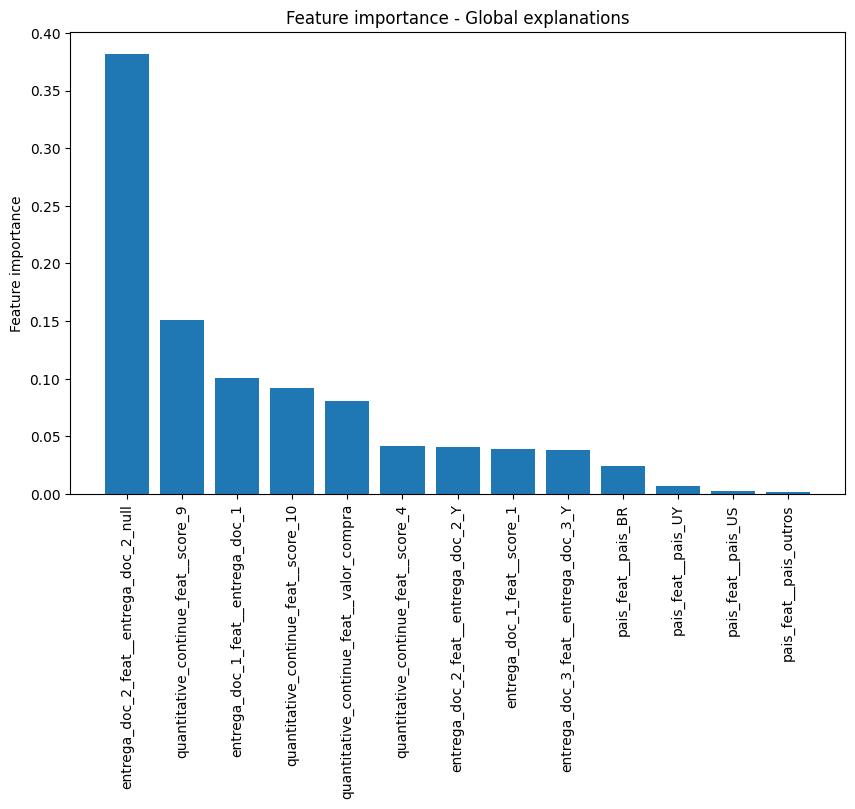

In [22]:
# Sort the DataFrame by the 'importance' column in descending order and plot it
global_exp_sorted = global_exp.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(global_exp_sorted.index, global_exp_sorted['importance'])
plt.ylabel("Feature importance")
plt.title("Feature importance - Global explanations")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Evaluate new model in test set

In [23]:
# select only the features that we are going to use
X_test = test_set.drop(['fraude'], axis=1)
y_test = test_set['fraude']

In [24]:
# Evaluate final model
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.98      0.77      0.86     21353
           1       0.15      0.77      0.25      1147

    accuracy                           0.77     22500
   macro avg       0.57      0.77      0.56     22500
weighted avg       0.94      0.77      0.83     22500

0.7684679186266181


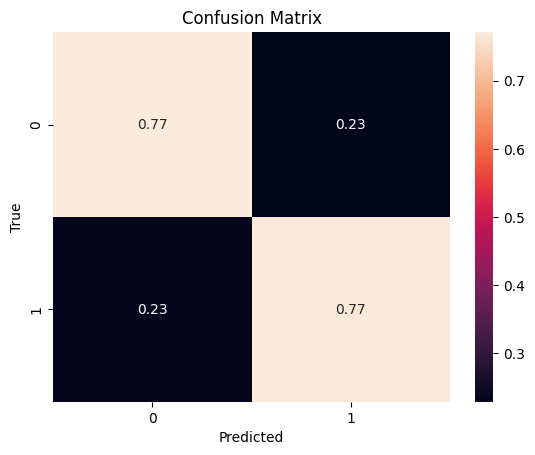

AUC: 0.7685



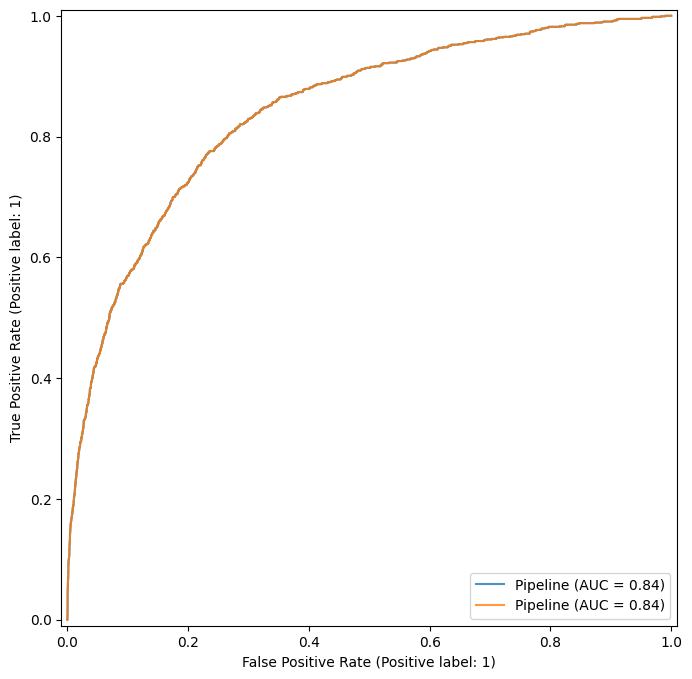

In [25]:
# print classification report
print(classification_report(y_test, final_predictions))
print(balanced_accuracy_score(y_test, final_predictions))

# plot confusion matrix
fig , ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, final_predictions, normalize='true'), annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_ylabel("True")
ax.set_xlabel("Predicted")
plt.show()

# print and plot roc_auc
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, final_predictions)))

plt.figure(figsize=(15, 8))
ax = plt.gca()
lgbm_disp = RocCurveDisplay.from_estimator(final_model, X_test, y_test, ax=ax, alpha=0.8)
lgbm_disp.plot(ax=ax, alpha=0.8)
plt.show()

# Business return of the new model

In [26]:
df_pred = pd.DataFrame({'y_test': y_test, 'final_predictions': final_predictions.reshape(-1)})
df_pred = pd.concat([X_test, df_pred], axis=1)

In [27]:
# calculate the revenue
revenues_new_model = df_pred.loc[(df_pred['y_test'] == 0) &
                                 (df_pred['final_predictions'] == 0)]
total_revenue_new_model = np.sum(revenues_new_model['valor_compra'].values)
total_revenue_new_model = total_revenue_new_model * 0.1

# calculate the fraud losses
losses_new_model = df_pred.loc[(df_pred['y_test'] == 1) &
                               (df_pred['final_predictions'] == 0)]
total_losses_new_model = np.sum(losses_new_model['valor_compra'].values)

# calculate the profit
total_profit_new_model = total_revenue_new_model - total_losses_new_model
total_profit_new_model

45899.518000000004

In [28]:
total_buy_value = np.sum(test_set['valor_compra'].values)

In [29]:
last_model_percentage = (41725.273 / total_buy_value) * 100
new_model_percentage = (total_profit_new_model / total_buy_value) * 100

print('We increased the percentage of profit in:', new_model_percentage - last_model_percentage, '%')

We increased the percentage of profit in: 0.43170227570484165 %
